In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import umap
import time
import skdim
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner import HyperModel, RandomSearch
from spatialinfo import spatial_information as si
from spatialinfo import dimensionality_utils as du

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
import matplotlib.cm as cm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOAD DATA

In [2]:
dff, bh = si.load_data(Path('..\\data\\processed_datasets\\20240903_Dc_1\\'))
bh = si.remove_interpolated_values(bh, n_corr=2)
bh = si.add_trial_column(bh)
activity_data, spatial_data = si.temporal_binning(dff, bh)

In [5]:
np.shape(activity_data)

(1828, 366)

## COMPUTE DIMENSIONALITY

In [4]:

abid_dim = np.nanmean(du.compute_abids(activity_data))
print(f"ABID: {abid_dim:.2f}", end='', flush=True)
time.sleep(.2)
    
mom_dim = skdim.id.MOM().fit_transform(activity_data,n_neighbors = 25)
print(f" | MOM: {mom_dim:.2f}", end='', flush=True)
time.sleep(.2)

tle_dim = skdim.id.TLE().fit_transform(activity_data,n_neighbors = 25)
print(f" | TLE: {tle_dim:.2f}", flush=True)
time.sleep(.2)

ABID: 3.25

 | MOM: 10.14 | TLE: 8.47


## COMPUTE UMAP

In [ ]:
model = umap.UMAP(n_neighbors =50, n_components =3, min_dist=0.08, metric="correlation")
model.fit(activity_data)
concat_emb = model.transform(activity_data)
np.shape(spatial_data)

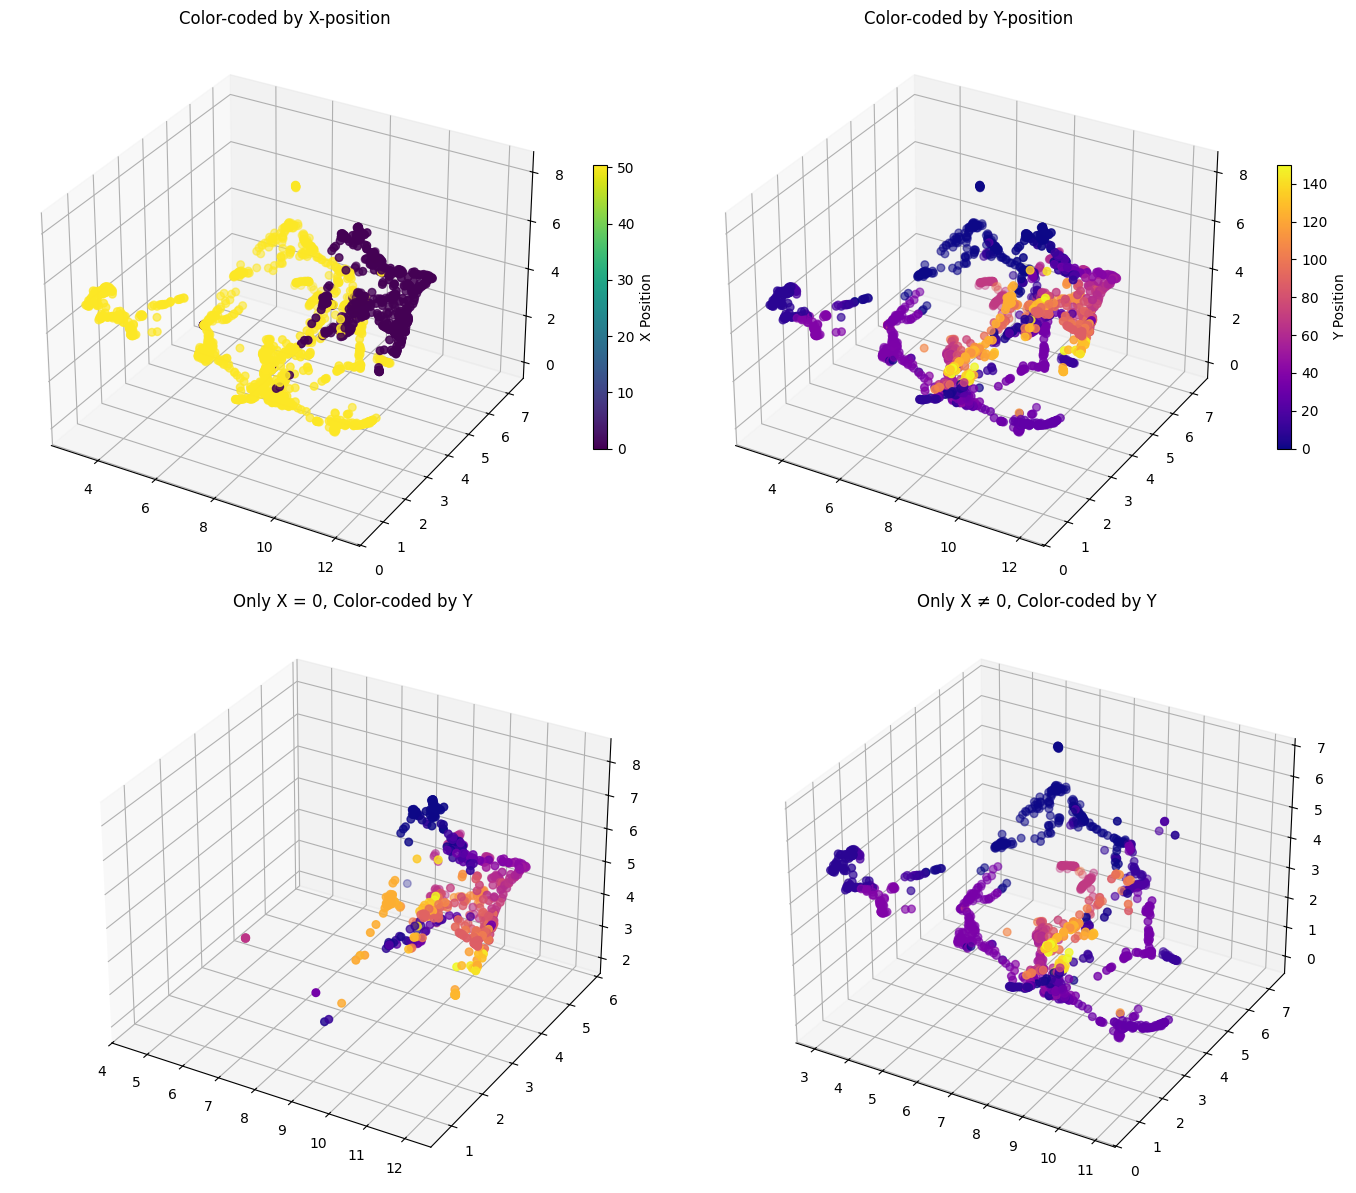

In [82]:
# Normalize x and y separately for color mapping
norm_x = Normalize(vmin=spatial_data[:, 0].min(), vmax=spatial_data[:, 0].max())
norm_y = Normalize(vmin=spatial_data[:, 1].min(), vmax=spatial_data[:, 1].max())

colors_x = cm.viridis(norm_x(spatial_data[:, 0]))  # Color by x
colors_y = cm.plasma(norm_y(spatial_data[:, 1]))  # Color by y

# Filter points where x = 0 and x ≠ 0
mask_x0 = spatial_data[:, 0] == 0
mask_x_nonzero = spatial_data[:, 0] != 0

# Create figure and 3D subplots
fig = plt.figure(figsize=(14, 12))

# Subplot 1: Color-coded by x-position
ax1 = fig.add_subplot(221, projection='3d')
sc1 = ax1.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_x, s=30)
ax1.set_title("Color-coded by X-position")


# Add colorbar for x
sm_x = cm.ScalarMappable(cmap="viridis", norm=norm_x)
sm_x.set_array([])
cbar_x = plt.colorbar(sm_x, ax=ax1, shrink=0.5)
cbar_x.set_label("X Position")

# Subplot 2: Color-coded by y-position
ax2 = fig.add_subplot(222, projection='3d')
sc2 = ax2.scatter(concat_emb[:, 0], concat_emb[:, 1], concat_emb[:, 2], c=colors_y, s=30)
ax2.set_title("Color-coded by Y-position")


# Add colorbar for y
sm_y = cm.ScalarMappable(cmap="plasma", norm=norm_y)
sm_y.set_array([])
cbar_y = plt.colorbar(sm_y, ax=ax2, shrink=0.5)
cbar_y.set_label("Y Position")

# Subplot 3: Only x = 0, color-coded by y-position
ax3 = fig.add_subplot(223, projection='3d')
sc3 = ax3.scatter(concat_emb[mask_x0, 0], concat_emb[mask_x0, 1], concat_emb[mask_x0, 2], 
                  c=cm.plasma(norm_y(spatial_data[mask_x0, 1])), s=30)
ax3.set_title("Only X = 0, Color-coded by Y")


# Subplot 4: Only x ≠ 0, color-coded by y-position
ax4 = fig.add_subplot(224, projection='3d')
sc4 = ax4.scatter(concat_emb[mask_x_nonzero, 0], concat_emb[mask_x_nonzero, 1], concat_emb[mask_x_nonzero, 2], 
                  c=cm.plasma(norm_y(spatial_data[mask_x_nonzero, 1])), s=30)
ax4.set_title("Only X ≠ 0, Color-coded by Y")


plt.tight_layout()
plt.show()